In [42]:
import pandas as pd
import numpy as np
df = pd.read_csv('Processed_Machine_Data.csv')

In [43]:
df_cleaned = pd.get_dummies(df, columns=['Type'], dtype=int)
print(df_cleaned.head())

   UDI Product ID  Air temperature [K]  Process temperature [K]  \
0    1     M14860                298.1                    308.6   
1    2     L47181                298.2                    308.7   
2    3     L47182                298.1                    308.5   
3    4     L47183                298.2                    308.6   
4    5     L47184                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Replace  \
0                    1551         42.8                0        0   
1                    1408         46.3                3        0   
2                    1498         49.4                5        0   
3                    1433         39.5                7        0   
4                    1408         40.0                9        0   

   Machine failure  TWF  HDF  PWF  OSF  RNF  Type_H  Type_L  Type_M  
0                0    0    0    0    0    0       0       0       1  
1                0    0    0    0    0    0     

In [44]:
# === BASIC DERIVED FEATURES ===
# Temperature Features
df_cleaned['Temperature_difference'] = df_cleaned['Process temperature [K]'] - df_cleaned['Air temperature [K]']
df_cleaned['Temperature_ratio'] = df_cleaned['Air temperature [K]'] / df_cleaned['Process temperature [K]']
df_cleaned['Temperature_average'] = (df_cleaned['Process temperature [K]'] + df_cleaned['Air temperature [K]']) / 2
df_cleaned['Temperature_product'] = df_cleaned['Process temperature [K]'] * df_cleaned['Air temperature [K]']
df_cleaned['Temp_diff_squared'] = df_cleaned['Temperature_difference'] ** 2
df_cleaned['Process_temp_normalized'] = df_cleaned['Process temperature [K]'] / 373.15  # Normalize by water boiling point
df_cleaned['Air_temp_normalized'] = df_cleaned['Air temperature [K]'] / 298.15  # Normalize by room temperature

# Power and Energy Features  
df_cleaned['Power'] = df_cleaned['Torque [Nm]'] * df_cleaned['Rotational speed [rpm]'] * (2 * np.pi / 60)  # Convert to Watts
df_cleaned['Power_per_1000'] = df_cleaned['Power'] / 1000  # kW
df_cleaned['Torque_per_RPM'] = df_cleaned['Torque [Nm]'] / (df_cleaned['Rotational speed [rpm]'] + 0.1)
df_cleaned['RPM_per_Torque'] = df_cleaned['Rotational speed [rpm]'] / (df_cleaned['Torque [Nm]'] + 0.1)
df_cleaned['Torque_squared'] = df_cleaned['Torque [Nm]'] ** 2
df_cleaned['RPM_squared'] = df_cleaned['Rotational speed [rpm]'] ** 2
df_cleaned['Power_squared'] = df_cleaned['Power'] ** 2

# Tool Wear Features
df_cleaned['Wear_per_RPM'] = df_cleaned['Tool wear [min]'] / (df_cleaned['Rotational speed [rpm]'] + 0.1)
df_cleaned['Wear_per_Torque'] = df_cleaned['Tool wear [min]'] / (df_cleaned['Torque [Nm]'] + 0.1)
df_cleaned['Wear_per_Power'] = df_cleaned['Tool wear [min]'] / (df_cleaned['Power'] + 0.1)
df_cleaned['Wear_squared'] = df_cleaned['Tool wear [min]'] ** 2
df_cleaned['Wear_log'] = np.log1p(df_cleaned['Tool wear [min]'])  # Log(1+x) to handle zeros
df_cleaned['Wear_sqrt'] = np.sqrt(df_cleaned['Tool wear [min]'])

# === WEAR RATE AND INTENSITY FEATURES ===

df_cleaned['Wear_rate_per_hour'] = df_cleaned['Tool wear [min]'] / 60  # Convert to hours
df_cleaned['Wear_velocity'] = df_cleaned['Tool wear [min]'] / (df_cleaned['UDI'] + 1)  # Wear per data point
df_cleaned['Wear_torque_interaction'] = df_cleaned['Tool wear [min]'] * df_cleaned['Torque [Nm]']

# === INTERACTION FEATURES ===

# Temperature-Wear Interactions
df_cleaned['Wear_x_TempDiff'] = df_cleaned['Tool wear [min]'] * df_cleaned['Temperature_difference']
df_cleaned['Wear_x_ProcessTemp'] = df_cleaned['Tool wear [min]'] * df_cleaned['Process temperature [K]']
df_cleaned['Wear_per_TempDiff'] = df_cleaned['Tool wear [min]'] / (df_cleaned['Temperature_difference'] + 1)
df_cleaned['Wear_temp_stress'] = df_cleaned['Tool wear [min]'] * df_cleaned['Temperature_ratio']
df_cleaned['Wear_per_avg_temp'] = df_cleaned['Tool wear [min]'] / ((df_cleaned['Process temperature [K]'] + df_cleaned['Air temperature [K]']) / 2)

# Mechanical Stress Interactions
df_cleaned['Torque_RPM_product'] = df_cleaned['Torque [Nm]'] * df_cleaned['Rotational speed [rpm]']
df_cleaned['Wear_mechanical_stress'] = df_cleaned['Tool wear [min]'] * df_cleaned['Torque_RPM_product'] / 1000
df_cleaned['Wear_x_Torque'] = df_cleaned['Tool wear [min]'] * df_cleaned['Torque [Nm]']
df_cleaned['Wear_x_RPM'] = df_cleaned['Tool wear [min]'] * df_cleaned['Rotational speed [rpm]']
df_cleaned['Wear_speed_stress'] = df_cleaned['Tool wear [min]'] * df_cleaned['Rotational speed [rpm]'] / 1000
df_cleaned['Wear_per_speed_squared'] = df_cleaned['Tool wear [min]'] / (df_cleaned['Rotational speed [rpm]']**2 + 1)

# Temperature-Mechanical Interactions
df_cleaned['TempDiff_x_Torque'] = df_cleaned['Temperature_difference'] * df_cleaned['Torque [Nm]']
df_cleaned['TempDiff_x_RPM'] = df_cleaned['Temperature_difference'] * df_cleaned['Rotational speed [rpm]']
df_cleaned['TempDiff_x_Power'] = df_cleaned['Temperature_difference'] * df_cleaned['Power']
df_cleaned['ProcessTemp_x_Power'] = df_cleaned['Process temperature [K]'] * df_cleaned['Power']

# === FAILURE MODE FEATURES ===

# Failure Mode Combinations
df_cleaned['Total_failures'] = df_cleaned['TWF'] + df_cleaned['HDF'] + df_cleaned['PWF'] + df_cleaned['OSF'] + df_cleaned['RNF']
df_cleaned['Multiple_failures'] = (df_cleaned['Total_failures'] > 1).astype(int)
df_cleaned['Any_failure'] = (df_cleaned['Total_failures'] > 0).astype(int)

# Specific Failure Interactions
df_cleaned['TWF_x_Wear'] = df_cleaned['TWF'] * df_cleaned['Tool wear [min]']
df_cleaned['HDF_x_TempDiff'] = df_cleaned['HDF'] * df_cleaned['Temperature_difference']
df_cleaned['PWF_x_Power'] = df_cleaned['PWF'] * df_cleaned['Power']
df_cleaned['OSF_x_RPM'] = df_cleaned['OSF'] * df_cleaned['Rotational speed [rpm]']
df_cleaned['RNF_x_Torque'] = df_cleaned['RNF'] * df_cleaned['Torque [Nm]']

# === EFFICIENCY AND PERFORMANCE FEATURES ===

# Efficiency Metrics
df_cleaned['Torque_efficiency'] = df_cleaned['Torque [Nm]'] / (df_cleaned['Power'] + 0.1)
df_cleaned['RPM_efficiency'] = df_cleaned['Rotational speed [rpm]'] / (df_cleaned['Power'] + 0.1)
df_cleaned['Thermal_efficiency'] = df_cleaned['Power'] / (df_cleaned['Temperature_difference'] + 1)
df_cleaned['Wear_efficiency'] = df_cleaned['Power'] / (df_cleaned['Tool wear [min]'] + 0.1)
df_cleaned['Wear_per_work'] = df_cleaned['Tool wear [min]'] / (df_cleaned['Power'] * df_cleaned['UDI'] + 1)  # Wear per unit work done

# Performance Ratios
df_cleaned['Power_per_temp'] = df_cleaned['Power'] / (df_cleaned['Process temperature [K]'] + 0.1)
df_cleaned['Torque_per_temp'] = df_cleaned['Torque [Nm]'] / (df_cleaned['Process temperature [K]'] + 0.1)
df_cleaned['RPM_per_temp'] = df_cleaned['Rotational speed [rpm]'] / (df_cleaned['Process temperature [K]'] + 0.1)

# === THRESHOLD-BASED FEATURES ===

# Wear Threshold Features
wear_percentiles = df_cleaned['Tool wear [min]'].quantile([0.25, 0.33, 0.5, 0.66, 0.75, 0.9, 0.95])

df_cleaned['Wear_above_p25'] = (df_cleaned['Tool wear [min]'] > wear_percentiles[0.25]).astype(int)
df_cleaned['Wear_above_p50'] = (df_cleaned['Tool wear [min]'] > wear_percentiles[0.5]).astype(int)
df_cleaned['Wear_above_p75'] = (df_cleaned['Tool wear [min]'] > wear_percentiles[0.75]).astype(int)
df_cleaned['Wear_above_p90'] = (df_cleaned['Tool wear [min]'] > wear_percentiles[0.9]).astype(int)
df_cleaned['Wear_critical'] = (df_cleaned['Tool wear [min]'] > wear_percentiles[0.95]).astype(int)

# Distance from thresholds
df_cleaned['Wear_dist_from_p90'] = df_cleaned['Tool wear [min]'] - wear_percentiles[0.9]
df_cleaned['Wear_dist_from_p95'] = df_cleaned['Tool wear [min]'] - wear_percentiles[0.95]

# Engineering Thresholds
df_cleaned['High_process_temp'] = (df_cleaned['Process temperature [K]'] > 320).astype(int)  # ~47°C
df_cleaned['High_temp_diff'] = (df_cleaned['Temperature_difference'] > 20).astype(int)
df_cleaned['Low_air_temp'] = (df_cleaned['Air temperature [K]'] < 295).astype(int)  # ~22°C
df_cleaned['High_torque'] = (df_cleaned['Torque [Nm]'] > 50).astype(int)
df_cleaned['High_RPM'] = (df_cleaned['Rotational speed [rpm]'] > 1500).astype(int)
df_cleaned['High_power'] = (df_cleaned['Power'] > 5000).astype(int)  # 5kW
df_cleaned['High_wear'] = (df_cleaned['Tool wear [min]'] > 150).astype(int)
df_cleaned['Low_wear'] = (df_cleaned['Tool wear [min]'] < 50).astype(int)

# === WEAR ANOMALY FEATURES ===

# Outlier Detection
Q1 = df_cleaned['Tool wear [min]'].quantile(0.25)
Q3 = df_cleaned['Tool wear [min]'].quantile(0.75)
IQR = Q3 - Q1

df_cleaned['Wear_is_outlier'] = ((df_cleaned['Tool wear [min]'] < (Q1 - 1.5 * IQR)) | 
                            (df_cleaned['Tool wear [min]'] > (Q3 + 1.5 * IQR))).astype(int)
df_cleaned['Wear_outlier_score'] = ((df_cleaned['Tool wear [min]'] - Q1) / IQR).clip(lower=0, upper=1)

# === COMPOSITE INDICES ===

# Risk Indices
df_cleaned['Thermal_risk'] = df_cleaned['Temperature_difference'] * df_cleaned['Process temperature [K]'] / 1000
df_cleaned['Mechanical_risk'] = df_cleaned['Torque [Nm]'] * df_cleaned['Rotational speed [rpm]'] / 1000
df_cleaned['Wear_risk'] = df_cleaned['Tool wear [min]'] * df_cleaned['Power'] / 1000
df_cleaned['Overall_risk'] = (df_cleaned['Thermal_risk'] + df_cleaned['Mechanical_risk'] + df_cleaned['Wear_risk']) / 3

# Performance Indices
df_cleaned['Machine_load'] = (df_cleaned['Torque [Nm]'] + df_cleaned['Rotational speed [rpm]']/10 + df_cleaned['Power']/100) / 3
df_cleaned['Thermal_load'] = df_cleaned['Temperature_difference'] * df_cleaned['Power'] / 1000
df_cleaned['Operational_intensity'] = df_cleaned['Power'] * df_cleaned['Tool wear [min]'] / 1000

# Wear Composite Scores
df_cleaned['Wear_composite_1'] = (df_cleaned['Tool wear [min]'] * df_cleaned['Torque [Nm]'] * df_cleaned['Rotational speed [rpm]']) / 10000
df_cleaned['Wear_composite_2'] = df_cleaned['Tool wear [min]'] * df_cleaned['Temperature_ratio'] * df_cleaned['Torque_per_RPM']

# === PRODUCT TYPE ENCODING ===

# Type-based interactions
df_cleaned['Type_L_x_Power'] = df_cleaned['Type_L'] * df_cleaned['Power']
df_cleaned['Type_M_x_Power'] = df_cleaned['Type_M'] * df_cleaned['Power']
df_cleaned['Type_H_x_Power'] = df_cleaned['Type_H'] * df_cleaned['Power']

df_cleaned['Type_L_x_Wear'] = df_cleaned['Type_L'] * df_cleaned['Tool wear [min]']
df_cleaned['Type_M_x_Wear'] = df_cleaned['Type_M'] * df_cleaned['Tool wear [min]']
df_cleaned['Type_H_x_Wear'] = df_cleaned['Type_H'] * df_cleaned['Tool wear [min]']

# === LOGARITHMIC AND ROOT TRANSFORMATIONS ===

# Log transformations (adding 1 to handle zeros)
df_cleaned['Log_RPM'] = np.log1p(df_cleaned['Rotational speed [rpm]'])
df_cleaned['Log_Torque'] = np.log1p(df_cleaned['Torque [Nm]'])
df_cleaned['Log_Power'] = np.log1p(df_cleaned['Power'])
df_cleaned['Log_TempDiff'] = np.log1p(df_cleaned['Temperature_difference'])

# Square root transformations
df_cleaned['Sqrt_RPM'] = np.sqrt(df_cleaned['Rotational speed [rpm]'])
df_cleaned['Sqrt_Torque'] = np.sqrt(df_cleaned['Torque [Nm]'])
df_cleaned['Sqrt_Power'] = np.sqrt(df_cleaned['Power'])

# === NORMALIZED FEATURES ===

# Min-Max style normalization (would need actual min/max from training data)
# These are examples - in practice, fit on training data
df_cleaned['RPM_norm'] = df_cleaned['Rotational speed [rpm]'] / 2000  # Assuming max ~2000
df_cleaned['Torque_norm'] = df_cleaned['Torque [Nm]'] / 100  # Assuming max ~100
df_cleaned['Wear_norm'] = df_cleaned['Tool wear [min]'] / 300  # Assuming max ~300
df_cleaned['TempDiff_norm'] = df_cleaned['Temperature_difference'] / 50  # Assuming max ~50

# === CATEGORICAL ENCODING ===

# Wear level categorization
df_cleaned['lv'] = pd.cut(
    df_cleaned['Tool wear [min]'],
    bins=[0, 100, 200, 260],
    labels=['低', '中', '高'],
    right=True,
    include_lowest=True
)

from sklearn.preprocessing import OrdinalEncoder
df_cleaned['lv_code'] = OrdinalEncoder(categories=[['低', '中', '高']]).fit_transform(df_cleaned[['lv']])

=== MIXED DATA TYPE CORRELATION ANALYSIS ===
Feature type distribution:
  Numerical: 92 features
  Categorical: 0 features
    []
  Binary: 22 features
  Datetime: 0 features
    []
  Other: 2 features
    ['Product ID', 'lv']

1. NUMERICAL-NUMERICAL CORRELATIONS


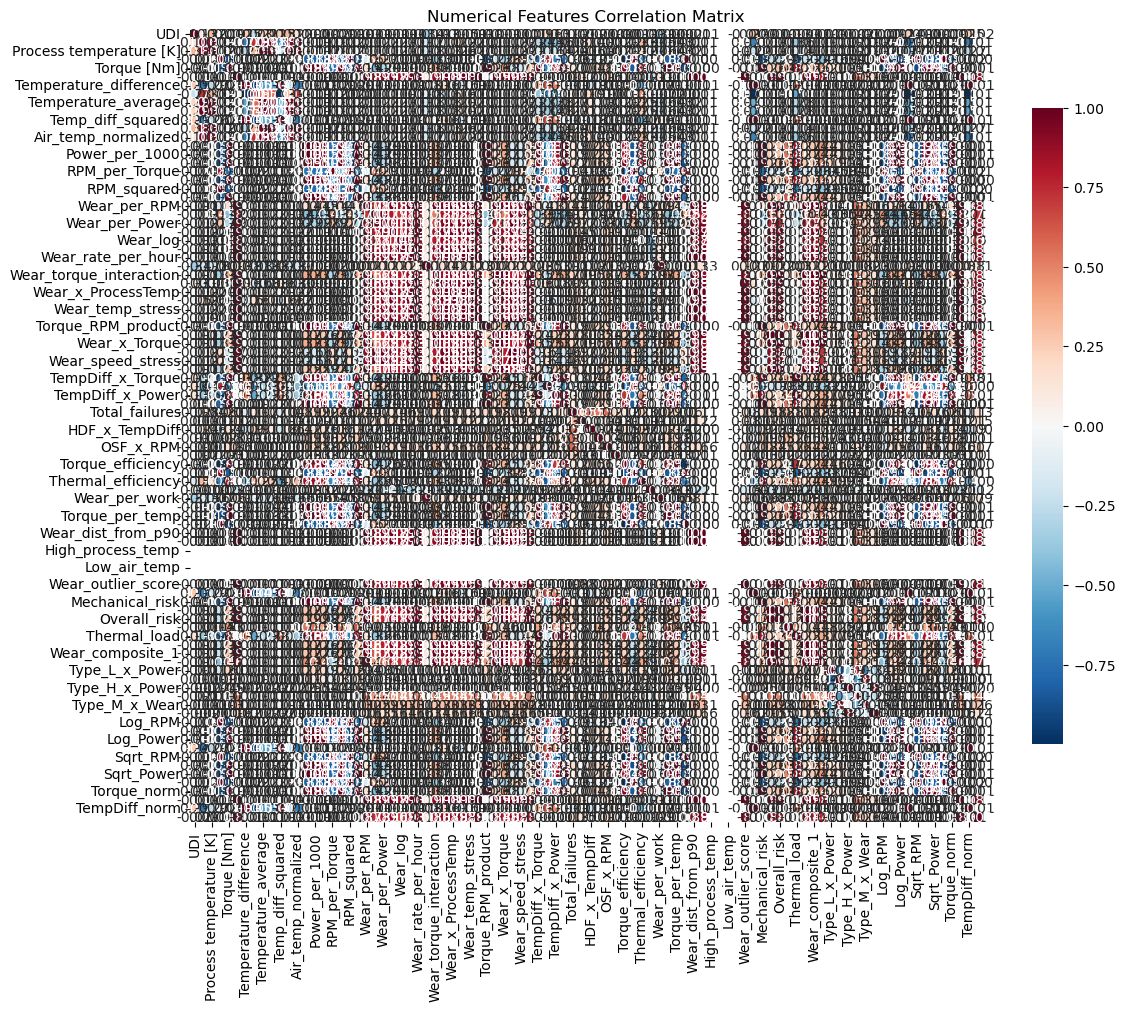

High numerical correlations (|r| >= 0.7):
  Power ↔ Torque_RPM_product: 1.000
  Torque_RPM_product ↔ Mechanical_risk: 1.000
  Wear_mechanical_stress ↔ Wear_composite_1: 1.000
  Process temperature [K] ↔ Process_temp_normalized: 1.000
  Power_per_1000 ↔ Torque_RPM_product: 1.000
  Power ↔ Mechanical_risk: 1.000
  Wear_mechanical_stress ↔ Wear_risk: 1.000
  Wear_mechanical_stress ↔ Operational_intensity: 1.000
  Air temperature [K] ↔ Air_temp_normalized: 1.000
  Rotational speed [rpm] ↔ RPM_norm: 1.000

4. BINARY-NUMERICAL CORRELATIONS (Point-biserial)


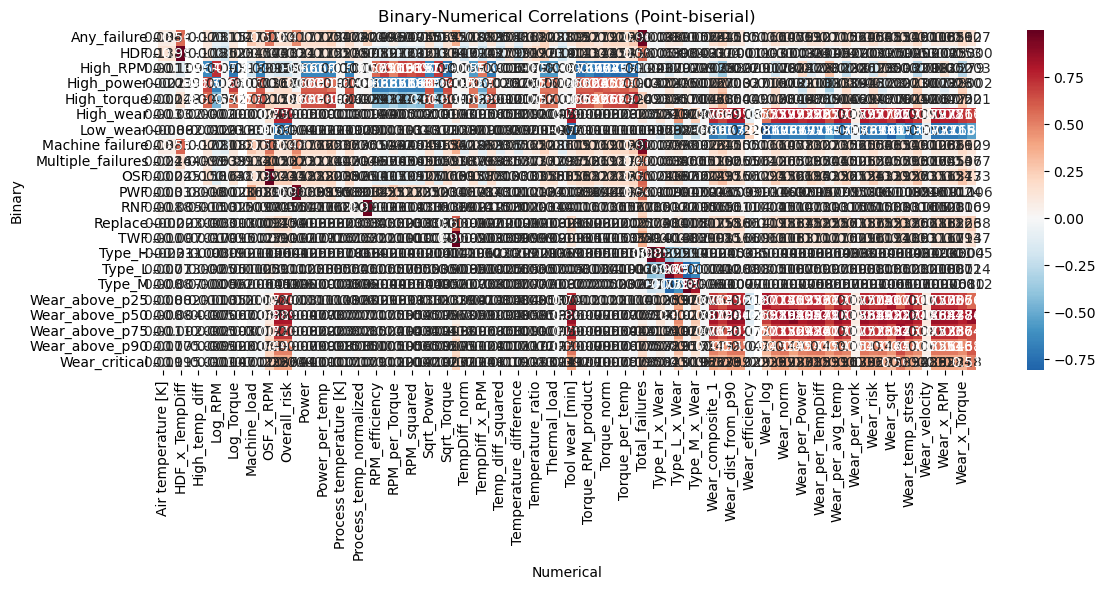


5. TARGET VARIABLE ANALYSIS: 'Replace'


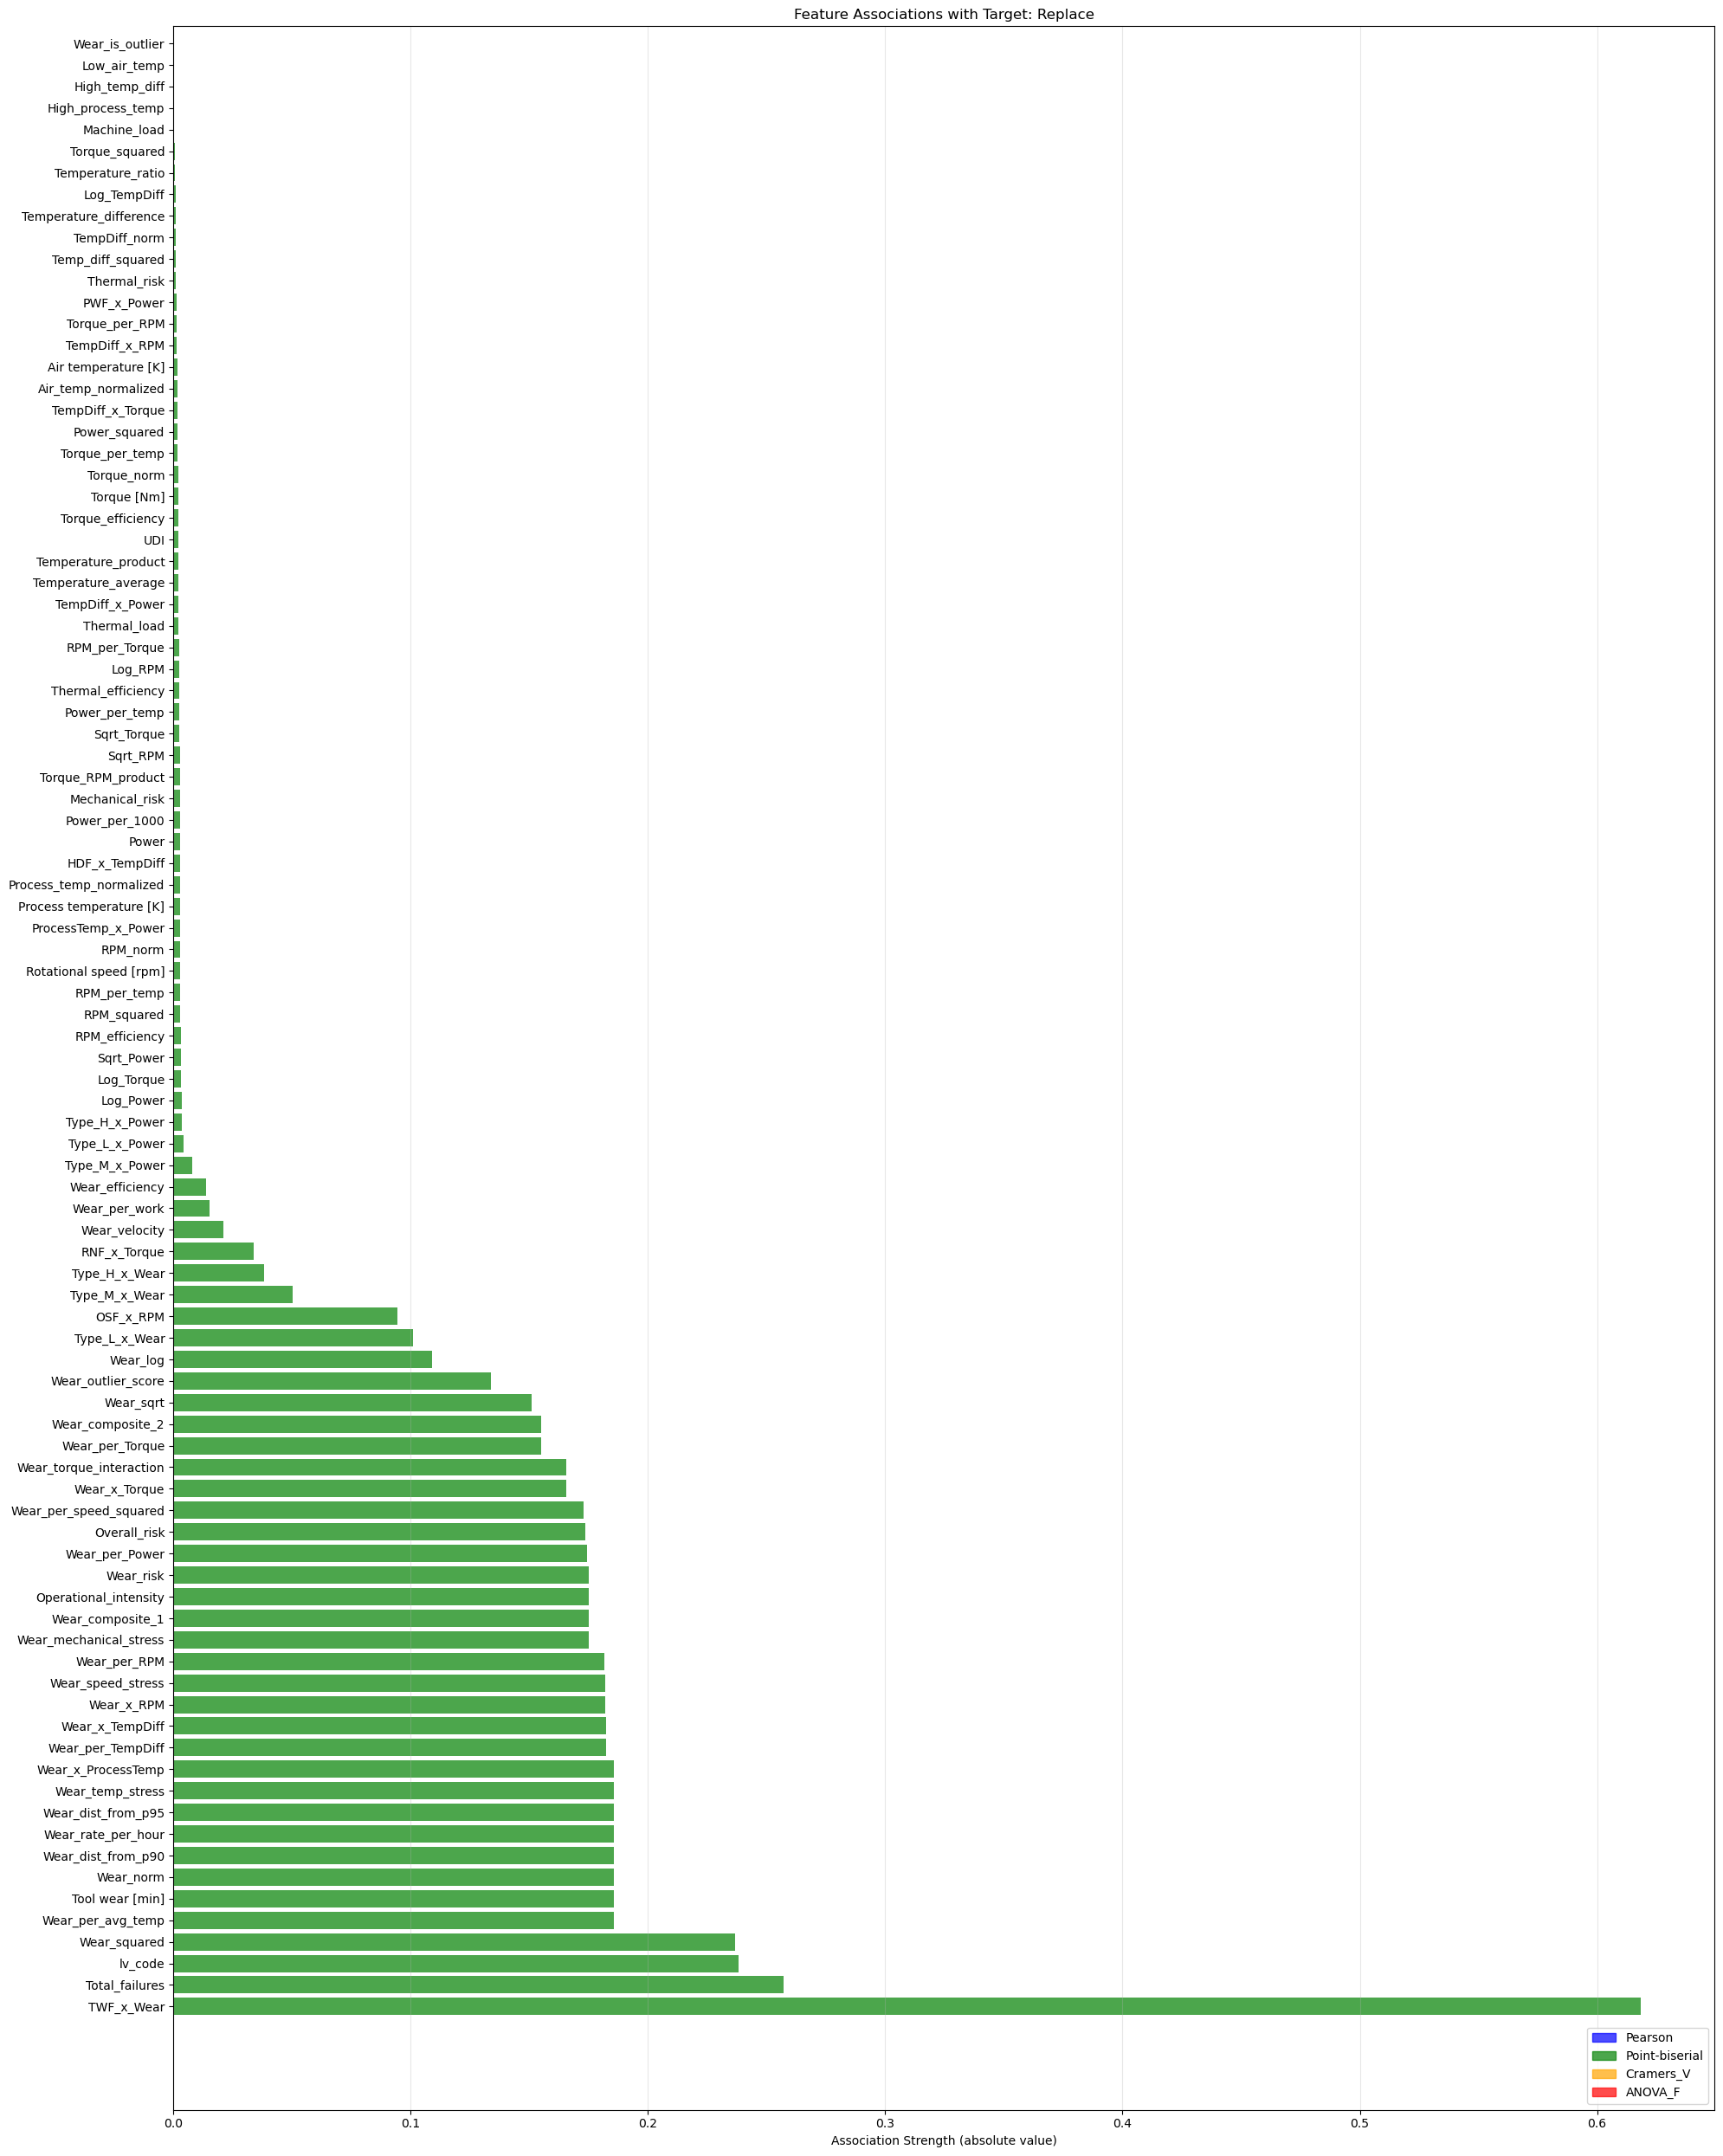


6. COMPREHENSIVE CORRELATION SUMMARY
Summary of strongest associations:

Top 10 strongest associations:
 1. Power ↔ Torque_RPM_product: 1.000 (Pearson)
 2. Torque_RPM_product ↔ Mechanical_risk: 1.000 (Pearson)
 3. Wear_mechanical_stress ↔ Wear_composite_1: 1.000 (Pearson)
 4. Process temperature [K] ↔ Process_temp_normalized: 1.000 (Pearson)
 5. Power_per_1000 ↔ Torque_RPM_product: 1.000 (Pearson)
 6. TWF_x_Wear ↔ TARGET: 0.618 (Point-biserial)
 7. Total_failures ↔ TARGET: 0.257 (Point-biserial)
 8. lv_code ↔ TARGET: 0.238 (Point-biserial)
 9. Wear_squared ↔ TARGET: 0.237 (Point-biserial)
10. Wear_per_avg_temp ↔ TARGET: 0.186 (Point-biserial)


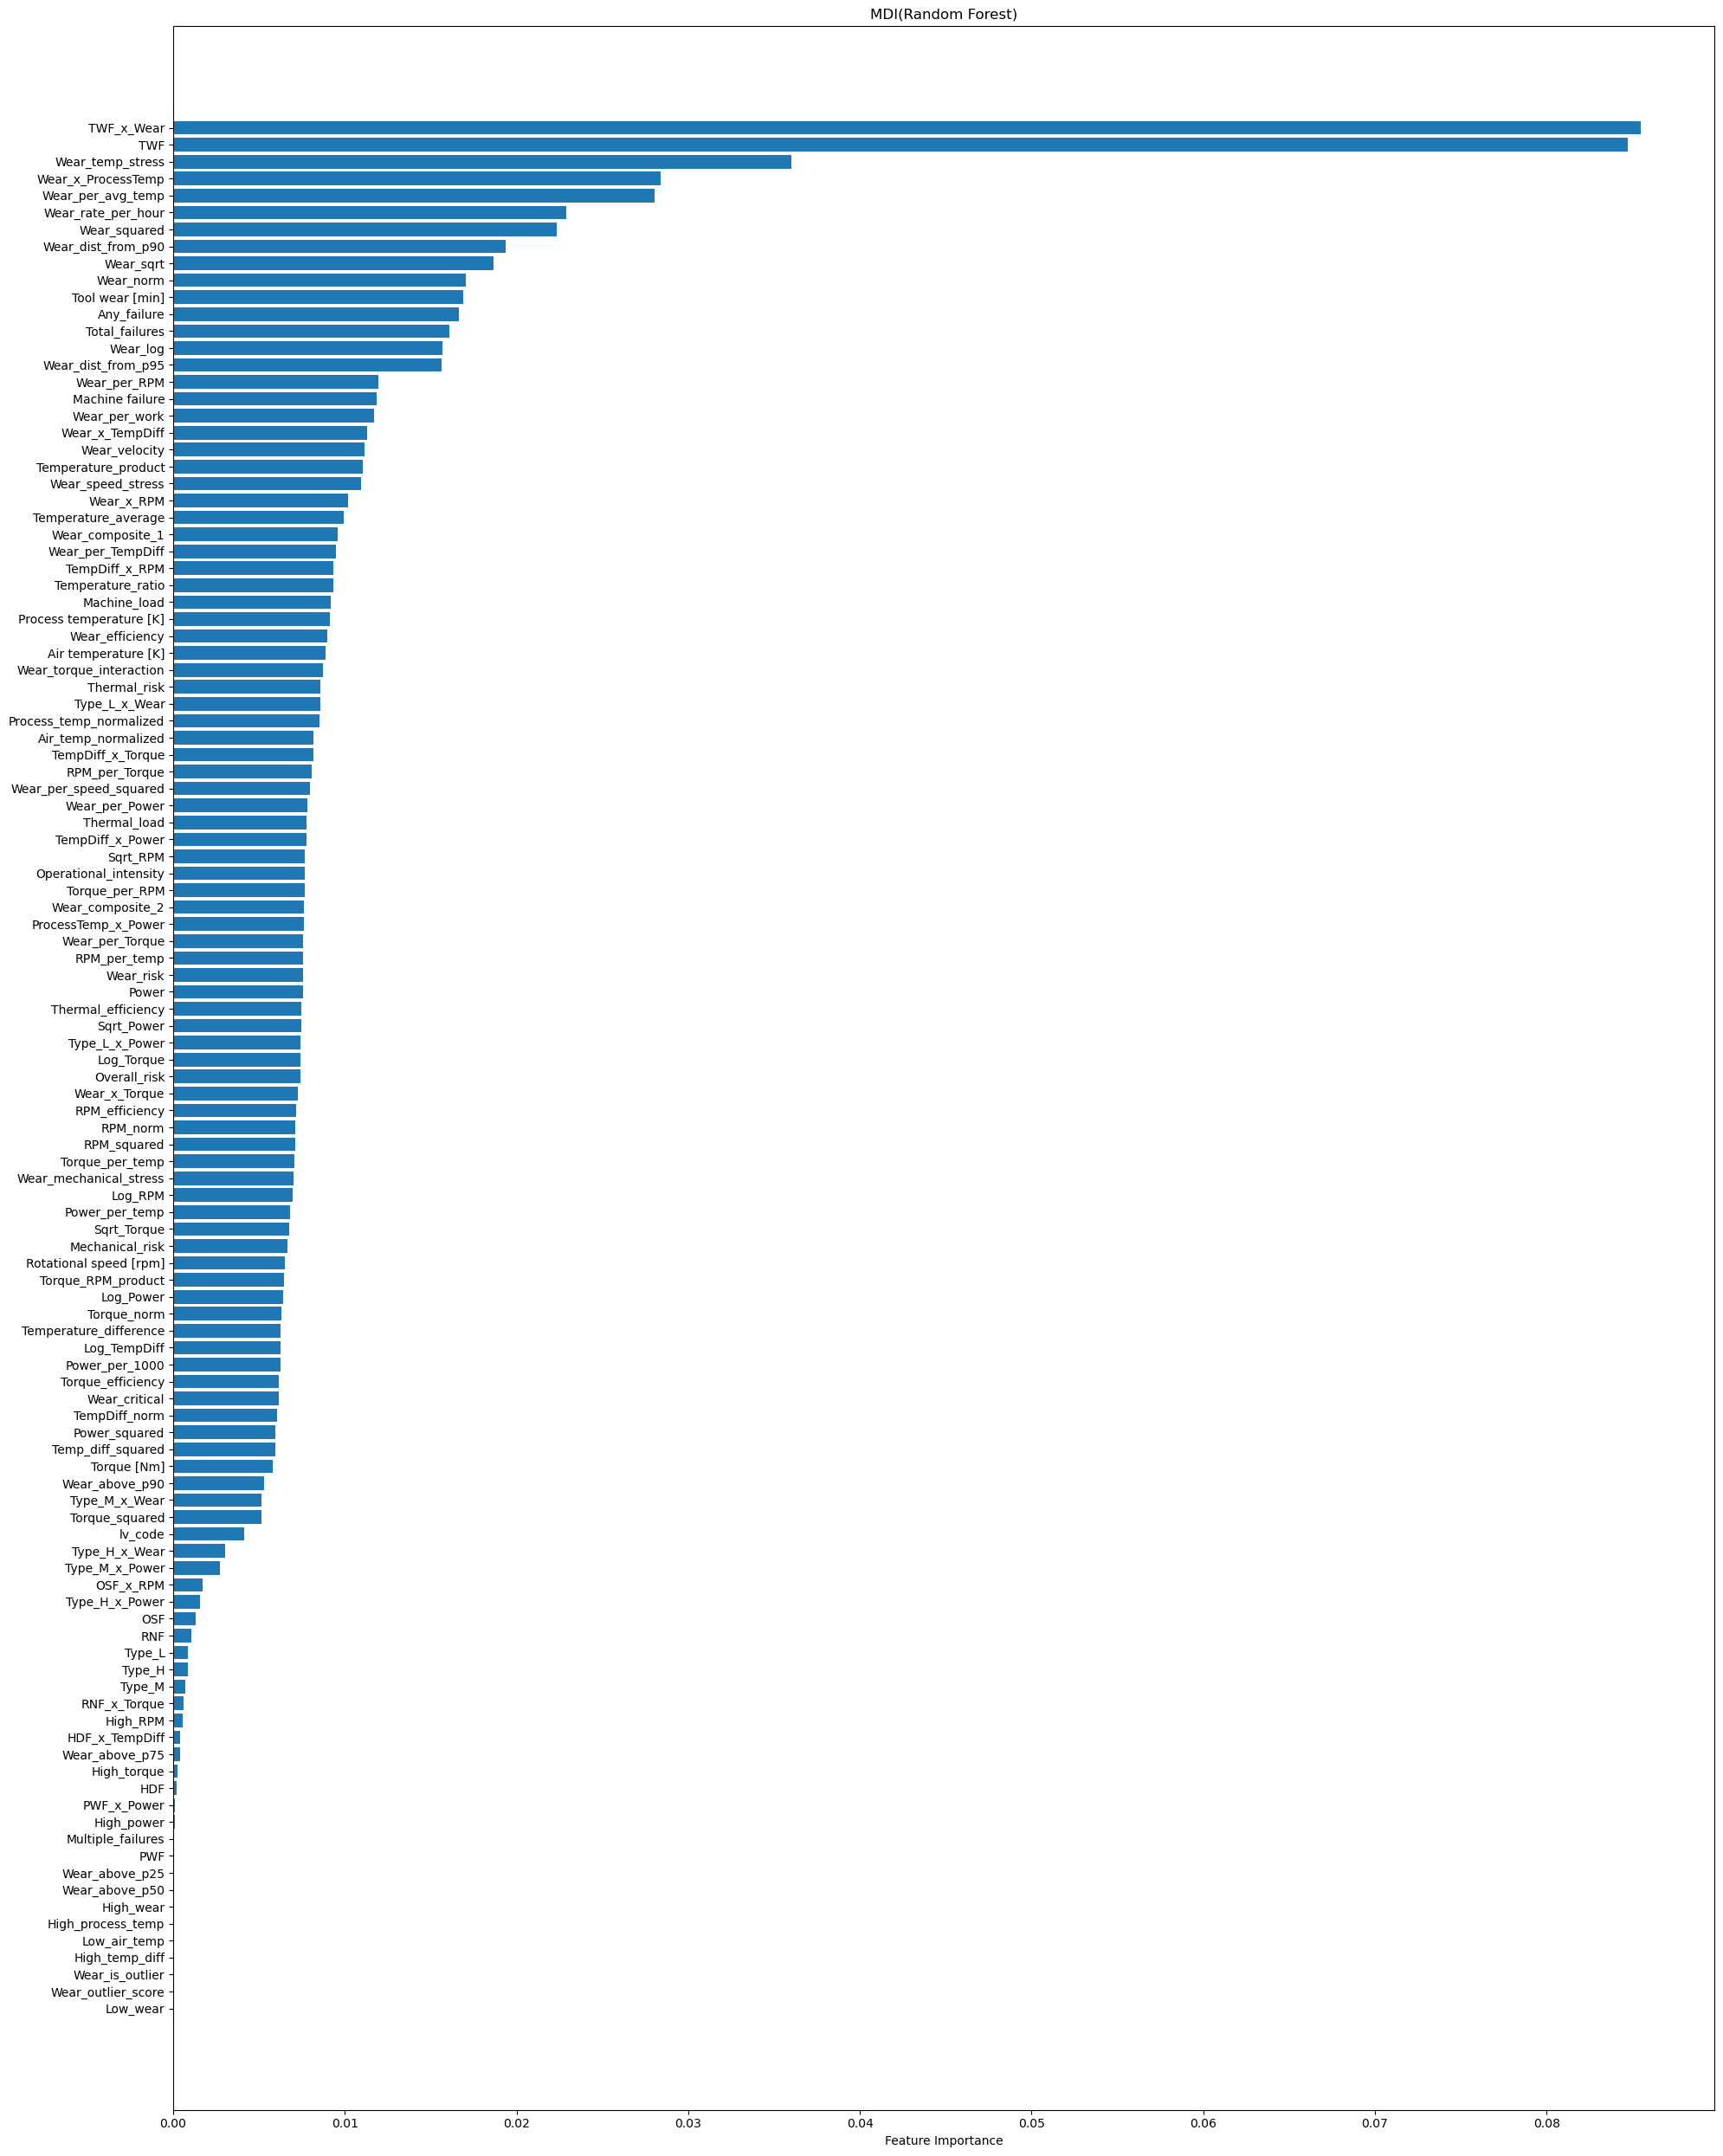

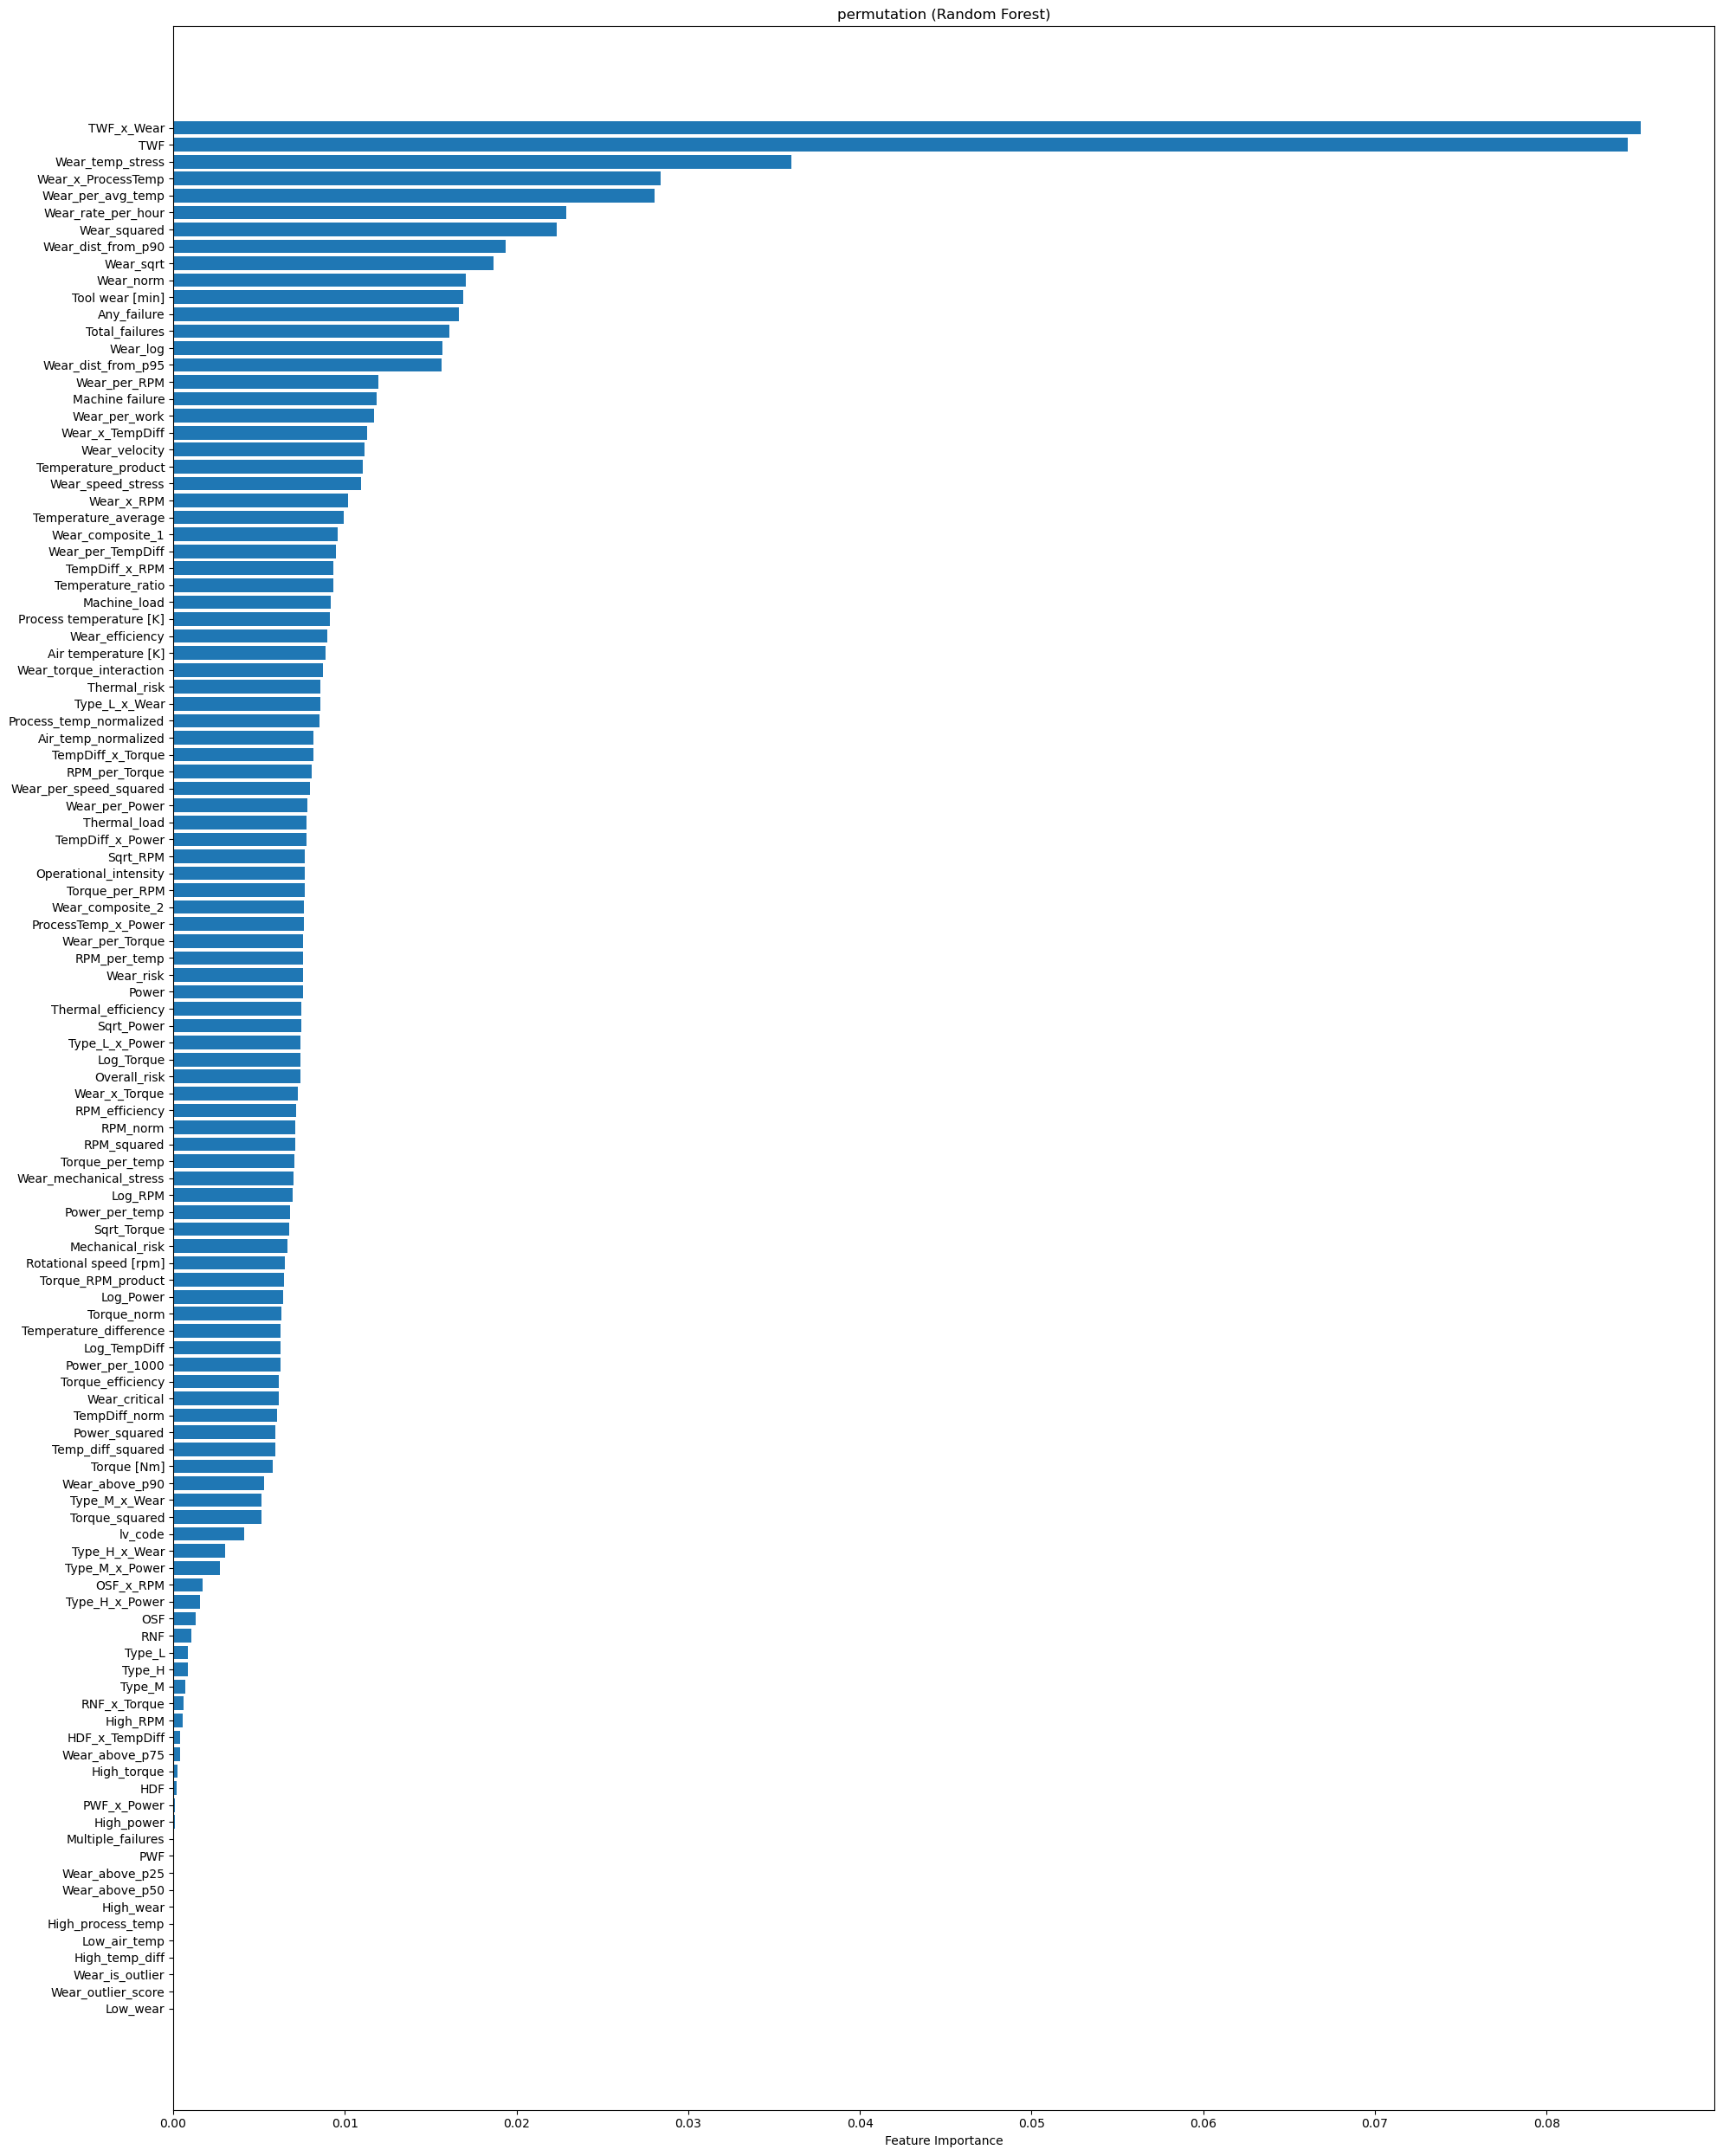

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from threshold_optimzation import analyze_mixed_correlations

X = df_cleaned.drop(columns=['Replace', 'lv', 'UDI', 'Product ID'])
y = df_cleaned['Replace']


corr_matrix = analyze_mixed_correlations(df_cleaned, target_col='Replace')



rf = RandomForestClassifier(n_estimators=300, class_weight= {0:1, 1:1.5}, oob_score=True, random_state=0)
rf.fit(X, y)

mdi = rf.feature_importances_ 
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': mdi
}).sort_values(by='Importance', ascending=False)

# 繪製視覺化
plt.figure(figsize=(20, 25))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.title("MDI(Random Forest)")
plt.tight_layout()
plt.show()
         # mean decrease impurity
perm = permutation_importance(rf, X, y,
                              n_repeats=10, random_state=0,
                              scoring="f1").importances_mean
feature_importance_perm_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(20, 25))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.title("permutation (Random Forest)")
plt.tight_layout()
plt.show()

In [46]:
from sklearn.model_selection import train_test_split

# 選定特徵與標籤
features = [
    'Tool_wear_roll_mean',
    'Wear per RPM',
    'Tool wear [min]',
    'Machine failure',
    'TWF_x_wear',
    'Rotational speed [rpm]',
    'Torque [Nm]', 
    'Power', 
    'Torque per RPM',
    'Temperature ratio',
    'lv_code',

    'Wear_rate_per_hour',
    'Wear_power_ratio',
    'Wear_per_torque',
    'Wear_torque_interaction',
]

features_t10 = [
    'Wear_norm',
    'Wear_dist_from_p90',
    'Wear_dist_from_p95',
    'Wear_rate_per_hour',
    'Tool wear [min]',
]

target_col = 'Replace'

X = df_cleaned[features_t10]
#X = df_cleaned.drop(columns=['Replace', 'lv', 'UDI', 'Product ID'])
y = df_cleaned[target_col]

# 切割資料集（80% 訓練集，20% 測試集），並維持標籤分布
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print('訓練集筆數:', X_train.shape[0])
print('測試集筆數:', X_test.shape[0])

訓練集筆數: 8000
測試集筆數: 2000


Fitting 10 folds for each of 1296 candidates, totalling 12960 fits
✅ 最佳參數：{'clf__max_depth': 7, 'clf__max_features': 4, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 40, 'clf__random_state': 42, 'smote__random_state': 7414, 'smote__sampling_strategy': 0.1}
✅ 最佳 F1-score：0.300
=== 交叉驗證過程 ===
第1折: 最佳門檻=0.80, F1-score=0.421
第2折: 最佳門檻=0.70, F1-score=0.270
第3折: 最佳門檻=0.80, F1-score=0.345
第4折: 最佳門檻=0.55, F1-score=0.390
第5折: 最佳門檻=0.55, F1-score=0.360
第6折: 最佳門檻=0.80, F1-score=0.320
第7折: 最佳門檻=0.80, F1-score=0.320
第8折: 最佳門檻=0.75, F1-score=0.326
第9折: 最佳門檻=0.65, F1-score=0.421
第10折: 最佳門檻=0.70, F1-score=0.245

最佳門檻平均值為 0.80
所有折中最佳 F1-score (失敗類): 0.421

=== 測試集 ===
最佳門檻為 0.80，此時 F1-score (失敗類) 為 0.316

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1976
           1       0.27      0.38      0.32        24

    accuracy                           0.98      2000
   macro avg       0.63      0.68      0.65      2000
weighted avg       0.9

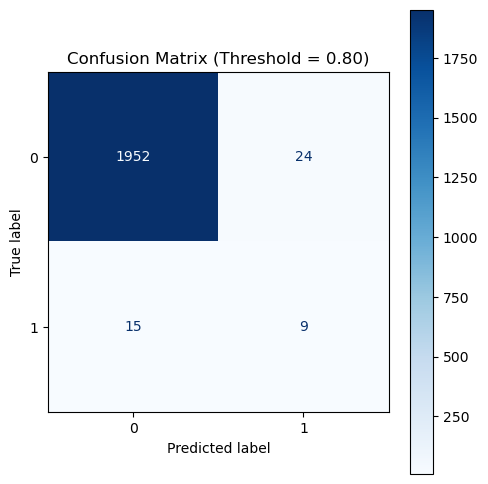

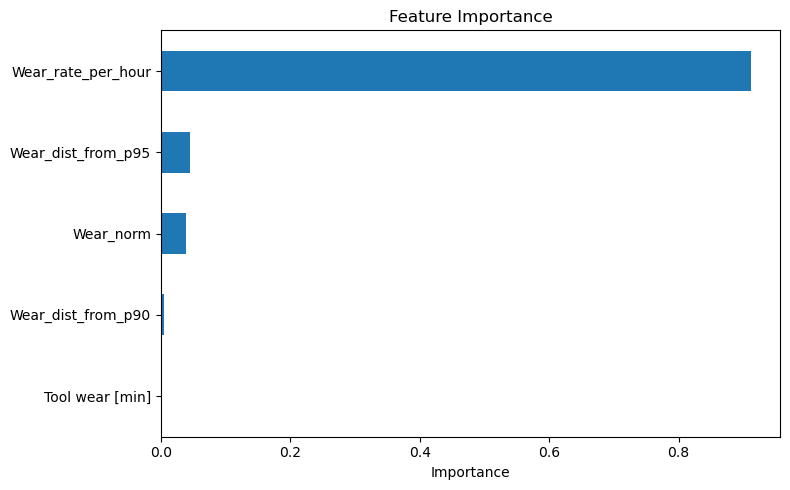

In [47]:
from sklearn.tree import DecisionTreeClassifier
from imblearn.combine import SMOTETomek
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

param_grid = {

    'smote__sampling_strategy': [0.1, 0.2, 'auto'],
    'smote__random_state': [42, 7414],  # for SMOTE component
    
    'clf__max_depth': [ 4, 5, 7],
    'clf__max_features': [ 4, 5, 'sqrt', 'log2'],
    'clf__min_samples_split': [ 40, 50, 70],
    'clf__min_samples_leaf': [5, 10, 15],
    'clf__random_state': [42, 7414],
}

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

pipe = Pipeline([
    ('smote', SMOTETomek()),
    ('clf', DecisionTreeClassifier(
        class_weight={0: 0.3, 1: 0.6},
        criterion='entropy',
        splitter='best'
    ))
])

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring='f1',     
    cv=skf,                 
    n_jobs=-1,             
    verbose=1               
)

grid.fit(X_train, y_train)
best_params = grid.best_params_
print(f"✅ 最佳參數：{best_params}")
print(f"✅ 最佳 F1-score：{grid.best_score_:.3f}")

pipe = grid.best_estimator_
thresholds = np.arange(0.5, 0.91, 0.05)

f1_list = []
best_thresholds = []

print("=== 交叉驗證過程 ===")
for fold, (train_idx, valid_idx) in enumerate(skf.split(X_train, y_train), 1):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[valid_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]
    
    pipe.fit(X_tr, y_tr)
    y_proba = pipe.predict_proba(X_val)[:, 1]

    best_f1 = 0
    best_thres = 0.5
    for thres in thresholds:
        y_pred = (y_proba >= thres).astype(int)
        f1 = f1_score(y_val, y_pred, pos_label=1)
        if f1 > best_f1:
            best_f1 = f1
            best_thres = thres
    print(f"第{fold}折: 最佳門檻={best_thres:.2f}, F1-score={best_f1:.3f}")
    f1_list.append(best_f1)
    best_thresholds.append(best_thres)

# 找出所有折最佳門檻的平均值
final_best_thres = np.max(best_thresholds)
print(f"\n最佳門檻平均值為 {final_best_thres:.2f}")
print(f"所有折中最佳 F1-score (失敗類): {np.max(f1_list):.3f}")

# 用最佳門檻評估測試集
pipe.fit(X_train, y_train)
y_proba_test = pipe.predict_proba(X_test)[:, 1]


y_pred_best = (y_proba_test >= final_best_thres).astype(int)

print(f"\n=== 測試集 ===")
print(f"最佳門檻為 {final_best_thres:.2f}，此時 F1-score (失敗類) 為 {f1_score(y_test, y_pred_best, pos_label=1):.3f}\n")
print(classification_report(y_test, y_pred_best, digits=2))



# 混淆矩陣
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax, cmap='Blues', values_format='d')  # 'd' 表示整數顯示
plt.title(f"Confusion Matrix (Threshold = {final_best_thres:.2f})")
plt.tight_layout()
plt.show()
import pandas as pd
# ===== 5. 特徵重要性視覺化 =====
clf = pipe.named_steps['clf']
importances = pd.Series(clf.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=True).plot.barh(figsize=(8, 5), title="Feature Importance")
plt.xlabel('Importance')
plt.tight_layout()
plt.show()